In [1]:
# Import packages and setup gpu configuration.
# This code block shouldnt need to be adjusted!
import os
import sys
import json
import yaml
import numpy as np
import math
import time
import random
from tqdm import tqdm
import webdataset as wds
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import utils
import h5py

from mae_utils import flat_models
from mae_utils.flat import load_nsd_flat_mask, load_nsd_flat_mask_visual
from mae_utils.flat import create_nsd_flat
import mae_utils.visualize as vis

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
# following fixes a Conv3D CUDNN_NOT_SUPPORTED error
torch.backends.cudnn.benchmark = True

### Multi-GPU config ###
device_count = torch.cuda.device_count()
print(f"Number of available CUDA devices: {device_count}")

local_rank = os.getenv('LOCAL_RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print(f"LOCAL RANK={local_rank}")

num_devices = os.getenv('NUM_GPUS')
if num_devices is None: 
    num_devices = 1
else:
    num_devices = int(num_devices)
print(f"NUM GPUS={num_devices}")
distributed = True if num_devices>1 else False
if distributed: assert device_count==num_devices

node = os.getenv('SLURM_NODEID')
if node is None:
    node = 0
else:
    node = int(node)
print(f"NODE={node}")

global_rank = os.getenv('RANK')
if global_rank is None:
    global_rank = 0
else:
    global_rank = int(global_rank)
print(f"GLOBAL RANK={global_rank}")

world_size = os.getenv('WORLD_SIZE')
if world_size is None: 
    world_size = 1
else:
    world_size = int(world_size)
print(f"WORLD_SIZE={world_size}")

if utils.is_interactive():
    # Following allows you to change functions in other files and 
    # have this notebook automatically update with your revisions
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

# Load parameters from yaml config
config = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)

print("\n__CONFIG__")
for attribute_name in config.keys():
    if global_rank==0:
        print(f"{attribute_name} = {config[attribute_name]}")
    globals()[attribute_name] = config[f'{attribute_name}']
print("\n")

# Create outdir for ckpt and config.yaml
outdir = os.path.abspath(f'checkpoints/{model_name}')
print("outdir", outdir)

# # Load previous config.yaml if available
# if os.path.exists(f"{outdir}/config.yaml"):
#     config = yaml.load(open(f"{outdir}/config.yaml", 'r'), Loader=yaml.FullLoader)
#     print(f"Loaded config.yaml from ckpt folder {outdir}")

#     # create global variables from the config
#     print("\n__REPLACING_CONFIG__")
#     for attribute_name in config.keys():
#         if global_rank==0:
#             print(f"{attribute_name} = {config[attribute_name]}")
#         globals()[attribute_name] = config[f'{attribute_name}']
#     print("\n")

data_type = torch.float32 # change depending on your mixed_precision
global_batch_size = batch_size * world_size

# FSDP Setup
if distributed:
    import torch.distributed as dist
    from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
    from torch.distributed.fsdp import MixedPrecision
    from torch.distributed.fsdp.api import BackwardPrefetch, CPUOffload, ShardingStrategy
    import functools
    from torch.distributed.fsdp.wrap import size_based_auto_wrap_policy, transformer_auto_wrap_policy
    print(f"setting device to cuda:{local_rank}")
    torch.cuda.set_device(local_rank)
    device = torch.device('cuda',local_rank)
    dist.init_process_group("nccl", rank=global_rank, world_size=world_size)
    print(f"\nSuccessfully set cuda:{local_rank} | global_rank{global_rank} | node{node}")
    dist.barrier() 
    print(f"global_rank{global_rank} passed barrier")
else:
    device = torch.device('cuda')

print("PID of this process =",os.getpid())
print("device =", device, "distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)

# setup wandb seed
if wandb_log and (wandb_rand==0):
    wandb_rand = str(np.random.randint(9998)+1)
    
# seed all random functions
utils.seed_everything(seed + global_rank)

Number of available CUDA devices: 1
LOCAL RANK=0
NUM GPUS=1
NODE=0
GLOBAL RANK=0
WORLD_SIZE=1

__CONFIG__
model_name = testest
datasets_to_include = NSD
hcp_flat_path = /weka/proj-medarc/shared/HCP-Flat
nsd_flat_path = /weka/proj-medarc/shared/NSD-Flat
model_size = small
global_pool = True
cls_forward = True
gsr = False
use_contrastive_loss = False
patch_size = 16
pct_masks_to_decode = 1
decoder_embed_dim = 512
num_frames = 16
mask_ratio = 0.75
pred_t_dim = 8
t_patch_size = 2
cls_embed = True
no_qkv_bias = False
sep_pos_embed = True
trunc_init = False
norm_pix_loss = False
contrastive_loss_weight = 1.0
batch_size = 24
num_workers = 10
num_epochs = 15
seed = 42
base_lr = 0.0003
num_samples_per_epoch = 200000
test_num_samples_per_epoch = 50000
grad_clip = 1.0
grad_accumulation_steps = 1
test_set = False
plotting = True
probe_num_samples_per_epoch = 100000
probe_num_epochs = 30
probe_batch_size = 8
probe_base_lr = 0.0003
ckpt_saving = True
ckpt_interval = 25
print_interval = 20
resume_fro

## Create dataset and data loaders

In [2]:
num_samples_per_epoch = 30000

flat_mask = load_nsd_flat_mask()
flat_mask_visual = load_nsd_flat_mask_visual()

num_batches = num_samples_per_epoch // (num_devices * batch_size)
print("num_batches", num_batches)

train_dataset = create_nsd_flat(root=nsd_flat_path, 
                frames=num_frames, shuffle=True,
                gsr=gsr, mindeye_only=True, only_shared1000=False)

train_dl = wds.WebLoader(
    train_dataset.batched(batch_size, partial=False),
    batch_size=None,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
train_dl = train_dl.with_epoch(num_batches)

num_batches 1250
Shuffle buffer size: 8428


### Prep test batches ahead of time to save time

In [3]:
# if local_rank==0:  

# COMMENTING OUT THE CODE THAT CREATED THE NUMPY FILES
# test_dataset = create_nsd_flat(root=nsd_flat_path, 
#                 frames=num_frames, shuffle=False,
#                 gsr=gsr, mindeye_only=True, only_shared1000=True)

# test_dl = wds.WebLoader(
#     test_dataset.batched(3000, partial=True),
#     batch_size=None,
#     shuffle=False,
#     num_workers=1,
#     pin_memory=True,
# )

# test_batches = None
# for i, batch in enumerate(test_dl):
#     if test_batches is None:
#         test_flatmaps = batch[0]
#         test_nsd_ids = batch[2]
#         print(test_flatmaps.shape, len(test_nsd_ids))
#     else:
#         test_flatmaps = torch.vstack((test_flatmaps, batch[0]))
#         test_nsd_ids = torch.hstack((test_nsd_ids, batch[2]))
#         print(test_flatmaps.shape, len(test_nsd_ids))
        
# np.save("shared1000_nsd_ids", test_nsd_ids.numpy())
# np.save("shared1000_flatmaps", test_flatmaps.numpy())

shared1000_nsd_ids = np.load("shared1000_nsd_ids.npy")
shared1000_flatmaps = np.load("shared1000_flatmaps.npy")

# group same-image repeats for test set
unique_ids, indices = np.unique(shared1000_nsd_ids, return_index=True)
group1_nsd_ids = unique_ids
group1_flatmaps = shared1000_flatmaps[indices]
print(group1_flatmaps.shape, len(group1_nsd_ids))

test_batches = [(group1_flatmaps, group1_nsd_ids)]

# shared1000_nsd_ids = np.delete(shared1000_nsd_ids, indices)
# unique_ids, indices = np.unique(shared1000_nsd_ids, return_index=True)
# group2_nsd_ids = unique_ids
# group2_flatmaps = shared1000_flatmaps[indices]
# print(group2_flatmaps.shape, len(group2_nsd_ids))

# shared1000_nsd_ids = np.delete(shared1000_nsd_ids, indices)
# unique_ids, indices = np.unique(shared1000_nsd_ids, return_index=True)
# group3_nsd_ids = unique_ids
# group3_flatmaps = shared1000_flatmaps[indices]
# print(group3_flatmaps.shape, len(group3_nsd_ids))

# test_batches = [(group1_flatmaps, group1_nsd_ids), (group2_flatmaps, group2_nsd_ids), (group3_flatmaps, group3_nsd_ids)]

(1000, 1, 16, 144, 320) 1000


## Create & load model

In [4]:
assert model_size in {"large", "small"}, "undefined model_size"

if model_size=="large":
    model = flat_models.mae_vit_large_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
    )
elif model_size=="small":
    model = flat_models.mae_vit_small_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
    )
utils.count_params(model)

img_size (144, 320) patch_size (16, 16) frames 16 t_patch_size 2
model initialized
param counts:
34,601,088 total
34,601,088 trainable


34601088

In [5]:
print("change mask to visual cortex only")
model.initialize_mask(flat_mask_visual)

try:
    checkpoint_files = [f for f in os.listdir(outdir) if f.endswith('.pth')]

    latest_checkpoint = "down3833_epoch99.pth"
    checkpoint_path = os.path.join(outdir, latest_checkpoint)
    print(f"latest_checkpoint: {checkpoint_path}")
    
    state = torch.load(checkpoint_path)
    model.load_state_dict(state["model_state_dict"], strict=False)
    
    print(f"\nLoaded checkpoint {latest_checkpoint} from {outdir}\n")
except:
    if local_rank==0:
        print("\n NO CHECKPOINT FOUND. STARTING MODEL FROM SCRATCH.\n")

change mask to visual cortex only

 NO CHECKPOINT FOUND. STARTING MODEL FROM SCRATCH.



In [6]:
# print("change mask to visual cortex only")
# model.initialize_mask(flat_mask_visual)

### Check data loaders work

Yielding 2 batches


  0%|                                                  | 0/1250 [00:00<?, ?it/s]

iter 0
input_func torch.Size([24, 1, 16, 144, 320])


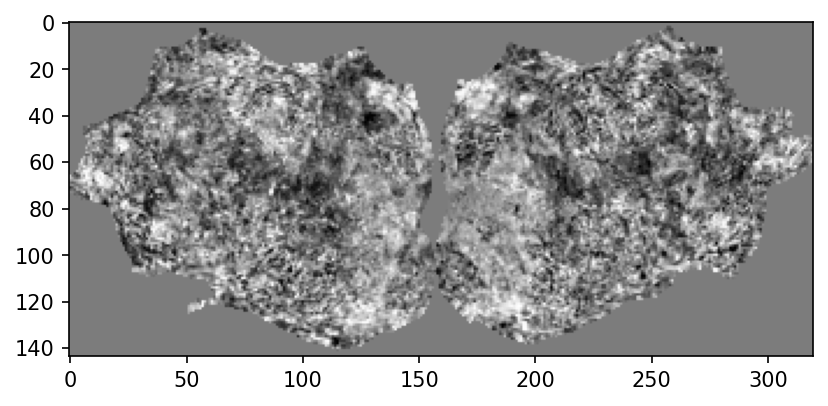

  0%|                                          | 1/1250 [00:02<52:08,  2.50s/it]

iter 1
input_func torch.Size([24, 1, 16, 144, 320])


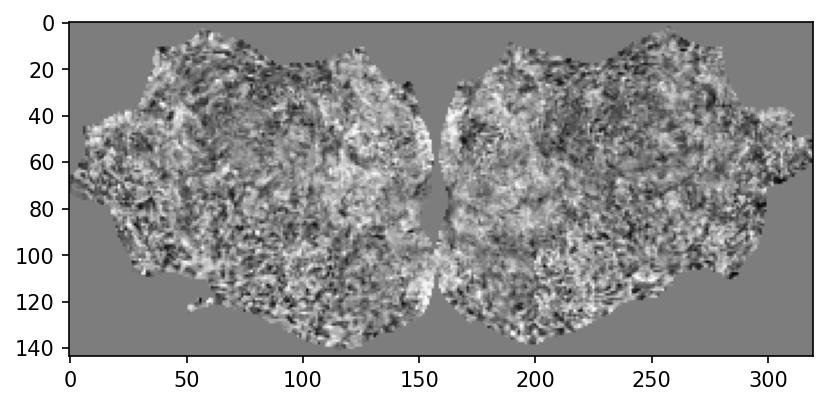

  0%|                                        | 2/1250 [00:09<1:35:56,  4.61s/it]

Execution time: 9.22754454612732 seconds


In [7]:
if utils.is_interactive():    
    start_time = time.time() 
    num_it = 2
    print(f"Yielding {num_it} batches")
    
    for i, batch in enumerate(tqdm(train_dl, total=num_batches)):
        input_func = batch[0]
        
        if i >= num_it:
            break
        print("iter",i)
        print("input_func", input_func.shape)
            
        plt.imshow(input_func[0,0,0], cmap='gray')
        plt.show()

    end_time = time.time()  
    execution_time = end_time - start_time  
    print(f"Execution time: {execution_time} seconds")

In [8]:
# Load 73k NSD images
data_path = "/weka/proj-medarc/shared/mindeyev2_dataset"
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu")

In [9]:
sys.path.append('mindeye_utils/')
import mindeye_utils.generative_models.sgm
from mindeye_utils.generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from mindeye_utils.generative_models.sgm.models.diffusion import DiffusionEngine
from omegaconf import OmegaConf

try:
    print(clip_img_embedder)
except:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=True,
        only_tokens=True,
    )
    clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

/admin/home-paulscotti/foundation_env/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/admin/home-paulscotti/foundation_env/lib/python3.11/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

In [10]:
# class MLP(torch.nn.Module):
#     def __init__(self, in_dim, h, out_dim): 
#         super(MLP, self).__init__()
#         self.projector = nn.Sequential(
#                             nn.LayerNorm(in_dim),
#                             nn.GELU(),
#                             nn.Linear(in_dim, h),
#                             nn.LayerNorm(h),
#                             nn.GELU(),
#                             nn.Linear(h, h),
#                             nn.LayerNorm(h),
#                             nn.GELU(),
#                             nn.Linear(h, out_dim)
#                         )
#     def forward(self, x):
#         return self.projector(x)
        
# model.downstream_mlp = MLP(in_dim=model.embed_dim, h=2048, out_dim=clip_seq_dim*clip_emb_dim)
# utils.count_params(model.downstream_mlp)
# utils.count_params(model)

In [11]:
hidden_dim=1024
n_blocks=4
clip_scale=1

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len=1): 
        super(RidgeRegression, self).__init__()
        self.seq_len = seq_len
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx=0):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(self.seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression([model.embed_dim], out_features=hidden_dim)

from functools import partial
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=1, n_blocks=n_blocks, drop=.15, 
                 clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        if clip_scale>0:
            self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b = torch.Tensor([0.]), torch.Tensor([[0.],[0.]])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        if clip_scale>0:
            c = self.clip_proj(backbone)
        
        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim)
utils.count_params(model.backbone)
utils.count_params(model)

param counts:
453,360,280 total
453,360,280 trainable
param counts:
488,355,608 total
488,355,608 trainable


488355608

In [12]:
# latest_checkpoint = "down3833_epoch99.pth"
# checkpoint_path = os.path.join(outdir, latest_checkpoint)
# print(f"latest_checkpoint: {checkpoint_path}")

# state = torch.load(checkpoint_path)
# model.load_state_dict(state["model_state_dict"], strict=True)

# print(f"\nLoaded checkpoint {latest_checkpoint} from {outdir}\n")

# Set up optimizer and saving functions

In [13]:
print(f"\nChecking distributed setup on global_rank {global_rank}...")
if distributed:
    from mae_utils.video_vit import Attention, PatchEmbed
    
    my_auto_wrap_policy = functools.partial(
        transformer_auto_wrap_policy, 
        transformer_layer_cls={Attention,PatchEmbed},
    )
    
    print(f"\nPrepping FSDP on {global_rank} {node}...\n")
    model = model.to(device)
    
    # FSDP
    model = FSDP(
        model,
        sharding_strategy=None, # ShardingStrategy.FULL_SHARD, 
        auto_wrap_policy=my_auto_wrap_policy,
        use_orig_params=False,
        cpu_offload=None, # CPUOffload(offload_params=True), 
        sync_module_states=True,  # Synchronize module states at the beginning
        limit_all_gathers=True,  # See https://github.com/pytorch/pytorch/issues/91165
        device_id=device,
        mixed_precision=MixedPrecision(param_dtype=torch.float32, reduce_dtype=torch.float32, buffer_dtype=torch.float32),
    )
    
    print(f"\nSuccessfully loaded FSDP model to device on global_rank {global_rank}\n")
    dist.barrier()
else:
    print(f"\nNot training distributed! global_rank {global_rank}")
    model.to(device)


Checking distributed setup on global_rank 0...

Not training distributed! global_rank 0


In [14]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
opt_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.05},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

lr = base_lr * global_batch_size / 256
print(f"multiply base lr {base_lr} by effective batch size {global_batch_size}")
print(f"lr = {lr}")

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=lr, betas=(0.9, 0.95))

def adjust_learning_rate(optimizer, epoch, warmup_epochs=5, min_lr=0.0):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < warmup_epochs:
        lr_ = lr * epoch / warmup_epochs
    else:
        lr_ = min_lr + (lr - min_lr) * 0.5 * (
            1.0
            + math.cos(
                math.pi
                * (epoch - warmup_epochs)
                / (num_epochs - warmup_epochs)
            )
        )
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr_
    return lr_

print("\nDone with model preparations!")
num_params = utils.count_params(model)

multiply base lr 0.0003 by effective batch size 24
lr = 2.8125e-05

Done with model preparations!
param counts:
488,355,608 total
488,355,608 trainable


In [15]:
def save_ckpt(model,tag="last"):
    if distributed: dist.barrier()
    model_states = model.state_dict()
    optimizer_states = optimizer.state_dict()
    if global_rank == 0:
        os.makedirs(outdir,exist_ok=True)
        ckpt_path = outdir+f'/{tag}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_states,
            'optimizer_state_dict': optimizer_states,
        }, ckpt_path)
        print(f"\n---saved {ckpt_path}!---\n")
        
        # save the config.yaml
        if not os.path.exists(f"{outdir}/config.yaml"):
            with open(f"{outdir}/config.yaml", 'w') as file:
                yaml.dump(config, file)
            print(f"saved {outdir}/config.yaml!")

# Load checkpoint

In [16]:
epoch = 0
# if resume_from_ckpt:
#     if not os.path.exists(outdir) or not os.path.isdir(outdir):
#         print(f"\nNot resuming from ckpt. Checkpoint folder {outdir} does not exist.\n")
#     else:
#         checkpoint_files = [f for f in os.listdir(outdir) if f.endswith('.pth')]

#         # Extract epoch numbers and find the largest
#         epoch_numbers = []
#         for file in checkpoint_files:
#             try:
#                 epoch_number = int(file.split('epoch')[-1].split('.')[0])
#                 epoch_numbers.append(epoch_number)
#             except ValueError:
#                 continue

#         latest_epoch = max(epoch_numbers)
#         latest_checkpoint = f"epoch{latest_epoch}.pth"

#         # Load the checkpoint
#         checkpoint_path = os.path.join(outdir, latest_checkpoint)

#         state = torch.load(checkpoint_path)
#         model.load_state_dict(state["model_state_dict"], strict=True)
#         epoch = state['epoch'] + 1
        
#         # Optimizer loading
#         saved_state_dict = state['optimizer_state_dict']
#         # adjust the saved state dict to match the current optimizer's structure
#         for i, group in enumerate(optimizer.param_groups):
#             # Ensure the params in the saved state match the current optimizer's params
#             saved_state_dict['param_groups'][i]['params'] = group['params']
#         optimizer.load_state_dict(saved_state_dict)

#         print(f"\nLoaded checkpoint {latest_checkpoint} from {outdir}. Epoch = {epoch}\n")

# Start wandb (if enabled)

In [17]:
if utils.is_interactive():
    print("Running inside interactive notebook. Disabling wandb and ckpt saving...")
    wandb_log = False
    ckpt_saving = False
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    print("wandb_rand", wandb_rand)
    wandb_project = 'fMRI-foundation-model'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "cls_embed": cls_embed,
      "norm_pix_loss": norm_pix_loss,
      "patch_size": patch_size,
      "t_patch_size": t_patch_size,
      "pred_t_dim": pred_t_dim,
      "mask_ratio": mask_ratio,
      "num_frames": num_frames,
      "sep_pos_embed": sep_pos_embed,
      "decoder_embed_dim": decoder_embed_dim,
      "use_contrastive_loss": use_contrastive_loss,
      "num_params": num_params,
      "base_lr": base_lr,
      "lr": lr,
      "num_samples_per_epoch": num_samples_per_epoch,
      "test_num_samples_per_epoch": test_num_samples_per_epoch,
      "test_set": test_set,
      "grad_clip": grad_clip,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "print_interval": print_interval,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "grad_accumulation_steps": grad_accumulation_steps,
      "world_size": world_size,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name + f"_FT_vizROI_ME2arch_2_{wandb_rand}")
    wandb.init(
        id=model_name + f"_FT_vizROI_ME2arch_2_{wandb_rand}",
        project=wandb_project,
        name=model_name + f"_FT_vizROI_ME2arch_2_{wandb_rand}",
        config=wandb_config,
        resume="allow",
    )
    
    # Reprint the config so that wandb captures it in the output log
    print("\n__CONFIG__")
    for attribute_name in config.keys():
        if global_rank==0:
            print(f"{attribute_name} = {config[attribute_name]}")
        globals()[attribute_name] = config[f'{attribute_name}']
    print("\n")
else:
    wandb_log = False

Running inside interactive notebook. Disabling wandb and ckpt saving...


# Start training

In [18]:
lrs, train_losses, test_losses = [], [], []
train_losses1, train_losses2, train_losses3 = [], [], []
fwd_percent_correct, bwd_percent_correct = [], []
test_fwd_percent_correct, test_bwd_percent_correct = [], []
mse = nn.MSELoss()

In [ ]:
grad_scaler = torch.amp.GradScaler(enabled=True)
progress_bar = tqdm(range(epoch, num_epochs), disable=local_rank!=0, desc="Overall")
for epoch in progress_bar:
    model.train()
    
    for train_i, batch in enumerate(train_dl):
        adjust_learning_rate(optimizer, train_i / num_batches + epoch)

        input_func = batch[0].to(device=device, non_blocking=True)

        image_batch = images[batch[2]].to(device=device, non_blocking=True)
        clip_target = clip_img_embedder(image_batch).float()

        latent = model(input_func, forward_features=True, global_pool=True)
        # latent_ = model.downstream_mlp(latent)

        voxel_ridge = model.ridge(latent.unsqueeze(1),0)
        backbone, latent_, blurry_image_enc_ = model.backbone(voxel_ridge)
        latent_ = latent_.flatten(1)
        
        # loss = mse(latent_, clip_target)
        clip_voxels_norm = nn.functional.normalize(latent_, dim=-1)
        clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
        loss = utils.soft_clip_loss(
            clip_voxels_norm,
            clip_target_norm,
            temp=.006)

        labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
        fwd_percent_correct.append(utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item())
        bwd_percent_correct.append(utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item())
        
        loss = loss / grad_accumulation_steps # normalize the loss by grad accumulation steps
        grad_scaler.scale(loss).backward()
        
        if (train_i + 1) % grad_accumulation_steps == 0:
            grad_scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            grad_scaler.step(optimizer)
            grad_scaler.update()
            optimizer.zero_grad()
            torch.cuda.synchronize()

        lrs.append(optimizer.param_groups[0]["lr"])
        train_losses.append(loss.item() * grad_accumulation_steps)
        
        if ((train_i%print_interval)==0 or (train_i==num_batches-1)) and train_i>0:
            # print(f"Ep. {epoch} | loss {np.mean(train_losses[-print_interval:]):.3f} | lr {optimizer.param_groups[0]['lr']} | {train_i}/{num_batches}")
            if wandb_log: 
                logs = {"train/loss": np.mean(train_losses[-print_interval:]),
                    "train/fwd_pct_correct": np.mean(fwd_percent_correct[-print_interval:]),
                    "train/bwd_pct_correct": np.mean(bwd_percent_correct[-print_interval:]),
                    }
                # epoch_1000x as x-axis calibrates different curves when batch size changes
                epoch_1000x = int((train_i / num_batches + epoch) * 1000)
                wandb.log(logs, step=epoch_1000x)
                
    if (train_i + 1) % grad_accumulation_steps != 0:
        print("update last batch that didnt divide evenly by grad accum.")
        grad_scaler.unscale_(optimizer)
        if not distributed:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
        else:
            model.clip_grad_norm_(max_norm=grad_clip)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        optimizer.zero_grad()
        torch.cuda.synchronize()

    model.eval()
    with torch.no_grad():
        for test_i, batch in enumerate(test_batches): 
            input_func = torch.Tensor(batch[0]).to(device).to(device=device, non_blocking=True)
            assert len(batch[1])==1000 # MindEye2 subj01 single-trial bs=1000 retrieval performance is 97.3% fwd 97.0% bwd

            image_batch = images[batch[1]].to(device=device, non_blocking=True)
            clip_target = clip_img_embedder(image_batch).float()

            latent = model(input_func, forward_features=True, global_pool=True)
            # latent_ = model.downstream_mlp(latent)

            voxel_ridge = model.ridge(latent.unsqueeze(1),0)
            backbone, latent_, blurry_image_enc_ = model.backbone(voxel_ridge)
            latent_ = latent_.flatten(1)
            
            # loss = mse(latent_, clip_target)
            clip_voxels_norm = nn.functional.normalize(latent_, dim=-1)
            clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
            loss = utils.soft_clip_loss(
                clip_voxels_norm,
                clip_target_norm,
                temp=.006)
    
            labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
            test_fwd_percent_correct.append(utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item())
            test_bwd_percent_correct.append(utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item())
    
            test_losses.append(loss.item())

    if local_rank==0:
        if utils.is_interactive() or wandb_log:
            print(f"Ep. {epoch} | loss {np.mean(train_losses[-print_interval:]):.3f} | fwd {np.mean(fwd_percent_correct[-print_interval:])} | bwd {np.mean(bwd_percent_correct[-print_interval:])} | lr {optimizer.param_groups[0]['lr']} | {train_i}/{num_batches}")
            print(f"Ep. {epoch} | test_loss {np.mean(test_losses[-(test_i+1):])} | fwd {np.mean(test_fwd_percent_correct[-(test_i+1):])} | bwd {np.mean(test_bwd_percent_correct[-(test_i+1):])}")
            if wandb_log:
                logs = {"test/loss": np.mean(test_losses[-(test_i+1):]),
                        "test/fwd_pct_correct": np.mean(test_fwd_percent_correct[-(test_i+1):]),
                        "test/bwd_pct_correct": np.mean(test_bwd_percent_correct[-(test_i+1):]),
                    }
                wandb.log(logs)
    
        # Save model checkpoint
        if ckpt_saving and epoch>0 and ((epoch % ckpt_interval == 0) or (epoch==num_epochs-1)):
            save_ckpt(model,f"downstream_epoch{epoch}")

    # wait for other GPUs to catch up if needed
    if distributed: dist.barrier()
    
if distributed: dist.destroy_process_group()

Overall:   0%|                                           | 0/15 [00:00<?, ?it/s]/weka/proj-fmri/paulscotti/fMRI-foundation-model/src/mindeye_utils/generative_models/sgm/util.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(
